# Introduction
- lassoでstackingを行う
- hyperopt でチューニングも行う

# Import everything I need :)

In [4]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from fastprogress import progress_bar

# Preparation

In [5]:
nb = 95
isSmallSet = False
length = 10000
model_name = 'lasso'

In [6]:
pd.set_option('display.max_columns', 200)

In [7]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/nb29_fc_train_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',

In [8]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
    
type_train = train.type.values

In [9]:
# train
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path) [:length]
else:
    test = pd.read_csv(path)
    
type_test = test.type.values

## myFunc
**metrics**

In [10]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Stacking

In [11]:
path_list = [
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb79_{}_extra_trees_regressor_-1.56760.csv',
'nb80_{}_extra_trees_regressor_-1.48000.csv',
'nb81_{}_bagging_regressor_-1.44452.csv',
'nb82_{}_bagging_regressor_-1.36181.csv',
'nb84_{}_extra_trees_regressor_-1.60943.csv',
'nb85_{}_extra_trees_regressor_-1.52972.csv',
'nb88_{}_lgb_-1.547953965914086.csv',
'nb91_{}_extra_trees_regressor_-1.47467.csv',
]

In [12]:
# oof
oofs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('oof'))
    oofs.append(df)

In [13]:
# sub
subs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)
    subs.append(df)

In [14]:
oof_list = [df.oof.values for df in oofs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_train

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
        y = train.scalar_coupling_constant.values
        axs[i].scatter(y[t_idx], oof_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('scalar_coupling_constant')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f15a06cee18> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f15a065d7b8> (for post_execute):


KeyboardInterrupt: 

# Create train, test data

LabelEncode
- `type`   = {2JHC, ...}

In [15]:
lbl = LabelEncoder()
lbl.fit(list(type_train) + list(type_test))
type_train_lbl = lbl.transform(type_train)
type_test_lbl = lbl.transform(type_test)

In [16]:
y = train.scalar_coupling_constant
X = pd.concat(oofs, axis=1)
X = pd.DataFrame(X.values, columns=path_list)
X_test = pd.concat(subs, axis=1)
X_test = pd.DataFrame(X_test.values, columns=path_list)
X['type'] = type_train_lbl
X_test['type'] = type_test_lbl

# Hyperopt

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.30, 
                                                  random_state = 0)

In [18]:
# Define searched space
log_list = np.logspace(-2, 1, 10)
hyper_space = {'alpha': hp.choice('alpha', log_list)}

# Seting the number of Evals
MAX_EVALS= 10
print(f'log_list: \n {log_list}')

log_list: 
 [ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]


In [19]:
%%time
# type ごとの学習 

best_params_list = []
# for t in sorted(X_train['type'].unique()):
for t in sorted(np.unique(type_train_lbl)):
    print('*'*80)
    print(f'- Training of type {t}')
    print('*'*80)
    X_t_train = X_train.loc[X_train['type'] == t]
    X_t_valid = X_valid.loc[X_valid['type'] == t]
    y_t_train = y_train[X_train['type'] == t]
    y_t_valid = y_valid[X_valid['type'] == t]
    
    
    # evaluate_metric
    def evaluate_metric(params):
        model = linear_model.Lasso(**params, random_state=42, max_iter=3000)  # <=======================
        model.fit(X_t_train, y_t_train)

        pred = model.predict(X_t_valid)
        y_t_train_pred = model.predict(X_t_train)

        _X_t_valid = X_t_valid.copy()
        _X_t_valid['scalar_coupling_constant'] = y_t_valid
        cv_score = kaggle_metric(_X_t_valid, pred)
        _X_t_valid = _X_t_valid.drop(['scalar_coupling_constant'], axis=1)

#         print(f'mae(valid): {mean_absolute_error(y_t_valid, pred)}')
        
        print(params)
        print(f'training l1: {mean_absolute_error(y_t_train, y_t_train_pred) :.5f}	\t valid l1: {mean_absolute_error(y_t_valid, pred) :.5f} ')
        print(f'cv_score: {cv_score}')
        print('-'*80)
        print('\n')

        return {
            'loss': cv_score,
            'status': STATUS_OK,
            'stats_running': STATUS_RUNNING
        }
    
    
    # hyperopt
    # Trail
    trials = Trials()

    # Set algoritm parameters
    algo = partial(tpe.suggest, 
                   n_startup_jobs=-1)


    # Fit Tree Parzen Estimator
    best_vals = fmin(evaluate_metric, space=hyper_space, verbose=1,
                     algo=algo, max_evals=MAX_EVALS, trials=trials)

    # Print best parameters
    best_params = space_eval(hyper_space, best_vals)
    best_params_list.append(best_params)
    print("BEST PARAMETERS: " + str(best_params))
    print('')

********************************************************************************
- Training of type 0
********************************************************************************
{'alpha': 4.6415888336127775}                       
training l1: 0.59192		 valid l1: 0.58962            
cv_score: -0.528268549606816                        
--------------------------------------------------------------------------------
{'alpha': 4.6415888336127775}                                                
training l1: 0.59192		 valid l1: 0.58962                                     
cv_score: -0.528268549606816                                                 
--------------------------------------------------------------------------------
{'alpha': 10.0}                                                              
training l1: 0.69922		 valid l1: 0.69732                                     
cv_score: -0.3605044299907867                                                
----------------------------

In [20]:
best_params_list

[{'alpha': 0.21544346900318834},
 {'alpha': 0.21544346900318834},
 {'alpha': 0.021544346900318832},
 {'alpha': 0.021544346900318832},
 {'alpha': 0.021544346900318832},
 {'alpha': 0.046415888336127774},
 {'alpha': 0.021544346900318832},
 {'alpha': 0.01}]

# Training model

**params**

In [21]:
# Configuration
MAX_ITER = 10000
RANDOM_STATE = 0

model_params_list = best_params_list

In [22]:
n_folds = 6
folds = KFold(n_splits=n_folds, shuffle=True)

In [23]:
def train_model(X, X_test, y, folds, model_params):
    model = linear_model.Ridge(**model_params, max_iter=MAX_ITER, random_state=RANDOM_STATE)  # <=================

    scores = []
    oof = np.zeros(len(X))  
    prediction = np.zeros(len(X))  
    result_dict = {}
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        model.fit(X.iloc[train_idx, :], y[train_idx])
        y_valid_pred = model.predict(X.iloc[valid_idx, :])
        y_train_pred = model.predict(X.iloc[train_idx, :])
        prediction = model.predict(X_test)
        oof[valid_idx] = y_valid_pred
        score = mean_absolute_error(y[valid_idx], y_valid_pred)
        score_train = mean_absolute_error(y[train_idx], y_train_pred)
        scores.append(score)

        print(f'fold {fold_n+1} train:{score_train :.5f} \t valid: {score :.5f}')
        print('')
    print('CV mean score    : {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('kaggle mean score: {0:.4f}'.format(np.log(np.mean(scores)))) 
    print('')
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    return result_dict

In [24]:
%%time
# type ごとの学習 

X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0] * len(X_test)})
for i, t in enumerate(np.unique(type_train)):
    idx = lbl.transform([t])[0]
    model_params = model_params_list[idx]
    print('*'*80)
    print(f'Training of type {t}')
    print('*'*80)
    print(model_params)
    X_t = X.loc[type_train == t]
    X_test_t = X_test.loc[type_test == t]
    y_t = X_short.loc[type_train == t, 'target'].values
    
    result_dict = train_model(X_t, X_test_t, y_t, folds, model_params)
    X_short.loc[type_train == t, 'oof'] = result_dict['oof']
    X_short_test.loc[type_test == t, 'prediction'] = result_dict['prediction']
    
    

print('')
print('===== finish =====')
X['scalar_coupling_constant'] = y
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']

********************************************************************************
Training of type 1JHC
********************************************************************************
{'alpha': 0.21544346900318834}
Fold 1 started at Wed Aug 28 17:24:22 2019
fold 1 train:0.54878 	 valid: 0.55099

Fold 2 started at Wed Aug 28 17:24:22 2019
fold 2 train:0.54944 	 valid: 0.54679

Fold 3 started at Wed Aug 28 17:24:22 2019
fold 3 train:0.54888 	 valid: 0.54970

Fold 4 started at Wed Aug 28 17:24:23 2019
fold 4 train:0.54948 	 valid: 0.54786

Fold 5 started at Wed Aug 28 17:24:23 2019
fold 5 train:0.54883 	 valid: 0.55086

Fold 6 started at Wed Aug 28 17:24:23 2019
fold 6 train:0.54939 	 valid: 0.54868

CV mean score    : 0.5491, std: 0.0015.
kaggle mean score: -0.5994

********************************************************************************
Training of type 1JHN
********************************************************************************
{'alpha': 0.21544346900318834}
Fold 1 sta

# Save

**submission**

In [25]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = f'../output/nb{nb}_stack_submission_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_submittion}')

save pash: ../output/nb95_stack_submission_lasso_-1.74192.csv


In [26]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
if isSmallSet:
    pass
else:
    submittion.to_csv(path_submittion, index=False)

---
**result**

In [27]:
path_oof = f'../output/nb{nb}_stack_oof_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_oof}')

save pash: ../output/nb95_stack_oof_lasso_-1.74192.csv


In [28]:
oof = pd.DataFrame(X_short['oof'])
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

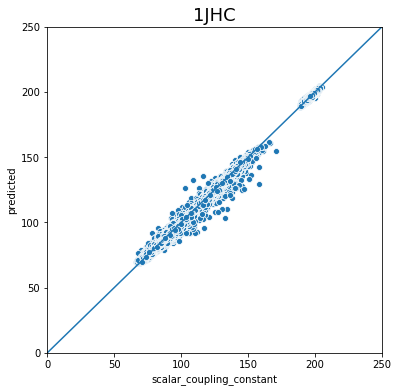

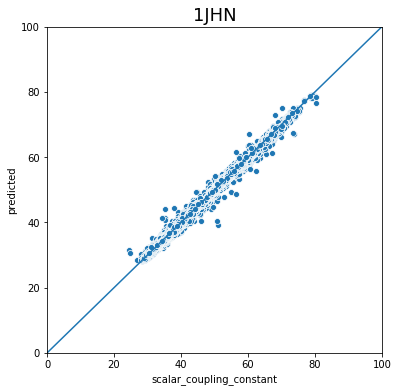

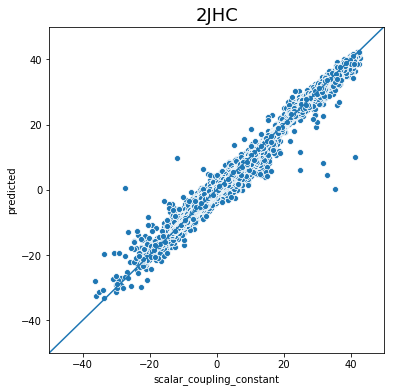

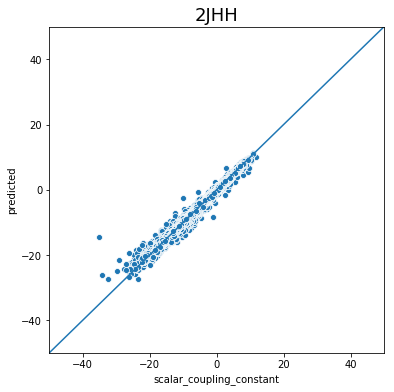

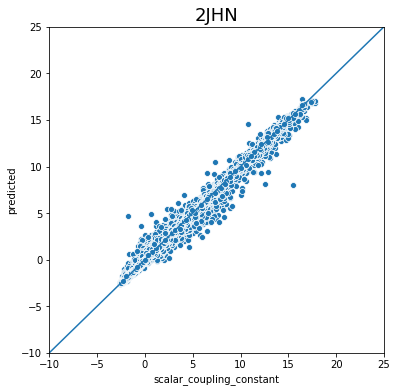

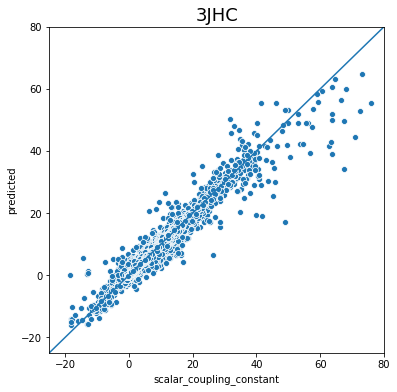

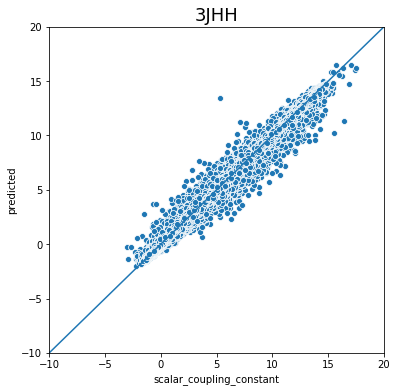

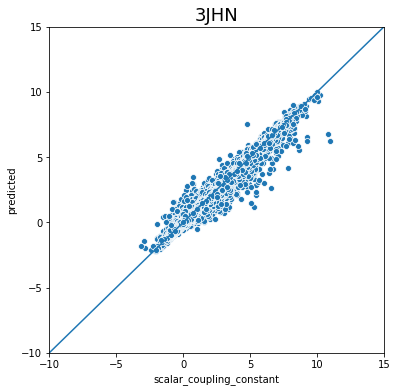

In [29]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 80)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)